In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
RANDOM_SEED = 42

Load Dataset

In [2]:
columns = ['user','activity','timestamp', 'xaxis', 'yaxis', 'zaxis']
df = pd.read_csv('/Users/jaenagaray/Documents/1 ITS Capstone Project Unit 1152/ITS Capstone Project Unit 1152/WISDM_ar_v1.1_raw.txt', 
                 header = None, names = columns, on_bad_lines='skip')
df = df.dropna()

In [3]:
df['zaxis'] = df['zaxis'].str.replace(';', '')

In [4]:
print('Total rows : ', len(df))
df.head()

Total rows :  1086467


,user,activity,timestamp,xaxis,yaxis,zaxis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.50395286
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209
3,33,Jogging,49106222305000,-0.612916,18.496431,3.0237172
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


Plot Activity Types

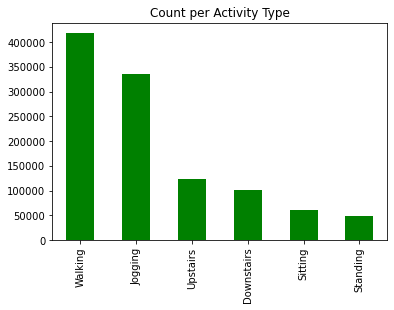

In [5]:
df['activity'].value_counts().plot(kind='bar', color = 'green', title='Count per Activity Type', );

In [6]:
display(df)

,user,activity,timestamp,xaxis,yaxis,zaxis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.50395286
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209
3,33,Jogging,49106222305000,-0.612916,18.496431,3.0237172
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
1086463,19,Sitting,131623331483000,9.000000,-1.570000,1.69
1086464,19,Sitting,131623371431000,9.040000,-1.460000,1.73
1086465,19,Sitting,131623411592000,9.080000,-1.380000,1.69
1086466,19,Sitting,131623491487000,9.000000,-1.460000,1.73


In [7]:
df.info

<bound method DataFrame.info of          user activity        timestamp     xaxis      yaxis        zaxis
0          33  Jogging   49105962326000 -0.694638  12.680544   0.50395286
1          33  Jogging   49106062271000  5.012288  11.264028   0.95342433
2          33  Jogging   49106112167000  4.903325  10.882658  -0.08172209
3          33  Jogging   49106222305000 -0.612916  18.496431    3.0237172
4          33  Jogging   49106332290000 -1.184970  12.108489     7.205164
...       ...      ...              ...       ...        ...          ...
1086463    19  Sitting  131623331483000  9.000000  -1.570000         1.69
1086464    19  Sitting  131623371431000  9.040000  -1.460000         1.73
1086465    19  Sitting  131623411592000  9.080000  -1.380000         1.69
1086466    19  Sitting  131623491487000  9.000000  -1.460000         1.73
1086467    19  Sitting  131623531465000  8.880000  -1.330000         1.61

[1086467 rows x 6 columns]>

In [8]:
len(df.index)

1086467

In [9]:
df['activity'].value_counts()

Walking       418393
Jogging       336446
Upstairs      122869
Downstairs    100426
Sitting        59939
Standing       48394
Name: activity, dtype: int64

In [10]:
# Round numbers
df = df.round({'xaxis': 4, 'yaxis': 4, 'zaxis': 4})

In [11]:
display(df)

,user,activity,timestamp,xaxis,yaxis,zaxis
0,33,Jogging,49105962326000,-0.6946,12.6805,0.50395286
1,33,Jogging,49106062271000,5.0123,11.2640,0.95342433
2,33,Jogging,49106112167000,4.9033,10.8827,-0.08172209
3,33,Jogging,49106222305000,-0.6129,18.4964,3.0237172
4,33,Jogging,49106332290000,-1.1850,12.1085,7.205164
...,...,...,...,...,...,...
1086463,19,Sitting,131623331483000,9.0000,-1.5700,1.69
1086464,19,Sitting,131623371431000,9.0400,-1.4600,1.73
1086465,19,Sitting,131623411592000,9.0800,-1.3800,1.69
1086466,19,Sitting,131623491487000,9.0000,-1.4600,1.73


Data Preprocessing

In [12]:
n_time_steps = 200
n_features = 3
steps = 20
segments = []
labels = []
for i in range(0, len(df) - n_time_steps, steps):
    xs = df['xaxis'].values[i: i + n_time_steps]
    ys = df['yaxis'].values[i: i + n_time_steps]
    zs = df['zaxis'].values[i: i + n_time_steps]
    label = stats.mode(df['activity'][i: i + n_time_steps])[0][0]
    segments.append([xs, ys, zs])
    labels.append(label)

In [13]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, n_time_steps, n_features)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [14]:
print(reshaped_segments.shape)
print(labels[0])

(54314, 200, 3)
[0. 1. 0. 0. 0. 0.]


In [15]:
display(reshaped_segments)

array([[[ -0.6946    ,   5.0123    ,   4.9033    ],
        [ -0.6129    ,  -1.185     ,   1.3757    ],
        [ -0.6129    ,  -0.504     ,  -8.431     ],
        ...,
        [  7.6273947 ,  -8.349273  ,   9.575105  ],
        [  2.2201166 ,   4.4810944 ,   0.08172209],
        [ -5.8567495 ,   7.1234417 ,  -9.112013  ]],

       [[  3.5685    ,  -0.504     ,  -2.3018    ],
        [ -3.5685    ,  -0.8036    ,   0.504     ],
        [  5.7069    ,  -8.6625    ,  -1.3348    ],
        ...,
        [  6.851035  ,  -8.19945   ,  -1.8387469 ],
        [  2.982856  ,   3.1054392 ,   0.88532263],
        [  8.349273  ,  -2.982856  ,  15.4046135 ]],

       [[  5.6661    ,   0.2315    ,  -4.8216    ],
        [  1.8387    ,  -3.2961    ,  11.6045    ],
        [ -3.1735    ,   0.6129    ,  -7.8862    ],
        ...,
        [-11.536434  ,  -8.812365  ,   4.2904096 ],
        [  2.2201166 ,   8.349273  ,   5.7886477 ],
        [ -9.888372  ,   1.7978859 ,  -1.334794  ]],

       ...,

      

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
        reshaped_segments, labels, test_size=0.20, random_state=RANDOM_SEED)

In [17]:
print('X_train : ', len(X_train))
print('X_test : ', len(X_test))

X_train :  43451
X_test :  10863


In [18]:
verbose = 1
epochs = 10
batch_size = 400

n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]
n_outputs = y_train.shape[1]

print('n_timesteps : ', n_timesteps)
print('n_features : ', n_features)
print('n_outputs : ', n_outputs)

n_timesteps :  200
n_features :  3
n_outputs :  6


In [19]:
metric = 'val_accuracy'
checkpoint = ModelCheckpoint("wisdm_cnn.h5", monitor=metric, verbose=1, 
                             save_best_only=True, save_weights_only=False, mode='auto', period=1)

In [20]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding = 'same'))
model.add(Dropout(0.4))
model.add(MaxPooling1D(pool_size=3))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

2023-04-23 13:08:20.735371: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
# Load Weights
final_model = Model(inputs = model.input, outputs = model.output)
#final_model.load_weights('./har_weights.h5')
final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit network
history = final_model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=epochs, batch_size=batch_size, callbacks = [checkpoint], verbose=verbose)

# evaluate model
(loss, accuracy) = final_model.evaluate(X_test, y_test, batch_size=batch_size, verbose=verbose)
print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss, accuracy * 100))

Epoch 1/10


2023-04-23 13:08:20.842232: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


109/109 [==============================] - 10s 92ms/step - loss: 1.9671 - accuracy: 0.5875 - val_loss: 0.4300 - val_accuracy: 0.8540

Epoch 00001: val_accuracy improved from -inf to 0.85400, saving model to wisdm_cnn.h5
Epoch 2/10
109/109 [==============================] - 9s 87ms/step - loss: 0.3736 - accuracy: 0.8665 - val_loss: 0.2431 - val_accuracy: 0.9184

Epoch 00002: val_accuracy improved from 0.85400 to 0.91844, saving model to wisdm_cnn.h5
Epoch 3/10
109/109 [==============================] - 10s 88ms/step - loss: 0.2256 - accuracy: 0.9213 - val_loss: 0.1950 - val_accuracy: 0.9429

Epoch 00003: val_accuracy improved from 0.91844 to 0.94293, saving model to wisdm_cnn.h5
Epoch 4/10
109/109 [==============================] - 10s 87ms/step - loss: 0.1738 - accuracy: 0.9431 - val_loss: 0.1519 - val_accuracy: 0.9534

Epoch 00004: val_accuracy improved from 0.94293 to 0.95342, saving model to wisdm_cnn.h5
Epoch 5/10
109/109 [==============================] - 9s 85ms/step - loss: 0.13

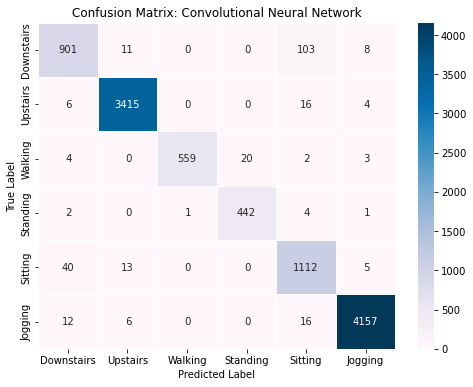

In [22]:
# Print confusion matrix for training data
y_pred_train = final_model.predict(X_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
#print(classification_report(trainy, max_y_pred_train))

# confusion matrix
classes = ['Downstairs', 'Upstairs', 'Walking', 'Standing', 'Sitting', 'Jogging']
y_pred_test = final_model.predict(X_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

matrix = metrics.confusion_matrix(max_y_test, max_y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, cmap='PuBu', linecolor='white', linewidths=1,
            xticklabels=classes, yticklabels=classes, annot=True, fmt='2d')
plt.title('Confusion Matrix: Convolutional Neural Network')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [23]:
print("Accuracy:",metrics.accuracy_score(max_y_test, max_y_pred_test))
print("Precision:",metrics.precision_score(max_y_test, max_y_pred_test, average = 'weighted', zero_division=1))
print("Recall:",metrics.recall_score(max_y_test, max_y_pred_test, average = 'weighted', zero_division=1))
print("F1-score:",metrics.f1_score(max_y_test, max_y_pred_test, average = 'weighted', zero_division=1))

Accuracy: 0.9745005983614103
Precision: 0.9750467019475141
Recall: 0.9745005983614103
F1-score: 0.9745454297107818
